In [ ]:
import numpy as np
import tensorflow as tf
import IPython.display as ipd
from librosa.feature.inverse import mfcc_to_audio
from pesq import pesq
from pystoi import stoi
from scipy import signal
from matplotlib import pyplot as plt
import random
import pandas as pd
import soundfile as sf

In [ ]:
def icmvn(mfcc, std_vec, mean_vec):
    return ((mfcc.T*std_vec)+mean_vec).T

def LSD(inverted_wav_X_original, inverted_wav_X, inverted_wav_y):
    f, t, true_spectrogram = signal.spectrogram(inverted_wav_y, fs) 
    f, t, ds_spectrogram = signal.spectrogram(inverted_wav_X_original, fs) 
    f, t, reco_spectrogram = signal.spectrogram(inverted_wav_X, fs)

    true_X = np.log10(np.abs(true_spectrogram)**2)
    ds_X = np.log10(np.abs(ds_spectrogram)**2)
    reco_X = np.log10(np.abs(reco_spectrogram)**2)
    ds_X_diff_squared = (true_X - ds_X)**2
    reco_X_diff_squared = (true_X - reco_X)**2
    ds_lsd = np.mean(np.sqrt(np.mean(ds_X_diff_squared, axis=0)))
    reco_lsd = np.mean(np.sqrt(np.mean(reco_X_diff_squared, axis=0)))

    return ds_lsd, reco_lsd

def predict_mfcc(model, mfcc, vector=False):

    predicted_mfcc = np.array([])

    # input 32 cols x N rows
    if vector==False:
        predicted_mfcc = np.array([model.predict_on_batch(np.matrix(vect))[0][:] for vect in mfcc])

    # input vector 32 * N
    else:
        predicted_mfcc = np.array([model.predict_on_batch(np.matrix(vect))[0][:] for vect in np.reshape(mfcc, (32, int(mfcc.shape[0]/32)))])

    return predicted_mfcc.T

In [ ]:
model_path = 'model_01/'
model = tf.keras.models.load_model(model_path)

In [ ]:
path = "arrays/"

X_val = np.load(f'{path}X_val.npy', fix_imports=False)
y_val = np.load(f'{path}y_val.npy', fix_imports=False)

y_val_stds = np.load(f'{path}y_val_stds.npy', fix_imports=False)
y_val_means = np.load(f'{path}y_val_means.npy', fix_imports=False)
X_val_stds = np.load(f'{path}X_val_stds.npy', fix_imports=False)
X_val_means = np.load(f'{path}X_val_means.npy', fix_imports=False)

X_val_framecounts = np.load(f'{path}X_val_framecounts.npy', fix_imports=False)
y_val_framecounts = np.load(f'{path}y_val_framecounts.npy', fix_imports=False)

In [ ]:
N = 150 # number of samples to evaluate

idxs = random.sample(range(X_val_framecounts.shape[0]), N) # without duplicates

mfcc_X_list = list()
start = 0

for ii, stop in enumerate(y_val_framecounts):
    if ii in idxs: 
        mfcc = X_val[int(start):int(start+stop),:]
        mfcc_X_list.append(mfcc)
    start = stop


mfcc_y_list = list()
start = 0

for ii, stop in enumerate(y_val_framecounts):
    if ii in idxs: 
        mfcc = y_val[int(start):int(start+stop),:]
        mfcc_y_list.append(mfcc)
    start = stop


y_val_stds = y_val_stds[idxs,:]
y_val_means = y_val_means[idxs,:]
X_val_stds = X_val_stds[idxs,:]
X_val_means = X_val_means[idxs,:]

# Statistics for N files

In [ ]:
errors = 0
inverse_error = 0

fs = 16000

stoi_scores = []
pesq_scores = []
LSD_reco_scores = []

stoi_ds_scores = []
pesq_ds_scores = []
LSD_ds_scores = []

kwargs = {'sr':fs, 'lifter':0.6, 'n_fft':640, 'hop_length':320, 'fmin':20, 'fmax':8000, 'n_mels':128}

for ii, (mfcc_X, mfcc_y, y_val_stds_, y_val_means_, X_val_stds_, X_val_means_) in enumerate(zip(mfcc_X_list, mfcc_y_list, y_val_stds, y_val_means, X_val_stds, X_val_means)):
    try:
        # predicted
        pred_mfcc_X = predict_mfcc(model, mfcc_X, False)
        pred_mfcc_X = icmvn(pred_mfcc_X, X_val_stds_, X_val_means_)

        inverted_wav_X_reco = mfcc_to_audio(mfcc=pred_mfcc_X, **kwargs)

        # corrupted 
        mfcc_X = icmvn(mfcc_X.T, X_val_stds_, X_val_means_) 

        inverted_wav_X_ds = mfcc_to_audio(mfcc=mfcc_X, **kwargs)

        # clear
        mfcc_y = icmvn(mfcc_y.T, y_val_stds_, y_val_means_)
        inverted_wav_y = mfcc_to_audio(mfcc=mfcc_y, **kwargs)
        
        #STOI
        stoi_score = stoi(inverted_wav_y, inverted_wav_X_reco, fs, extended=False)
        stoi_ds_score = stoi(inverted_wav_y, inverted_wav_X_ds, fs, extended=False)

        #LSD
        ds_lsd, reco_lsd = LSD(inverted_wav_X_ds, inverted_wav_X_reco, inverted_wav_y)

        #PESQ
        try:
            pesq_score = pesq(fs, inverted_wav_y, inverted_wav_X_reco,'wb')
            pesq_ds_score = pesq(fs, inverted_wav_y, inverted_wav_X_ds,'wb')

            # if error occures statistics are dropped
            stoi_scores.append(stoi_score)
            pesq_scores.append(pesq_score)
            LSD_reco_scores.append(reco_lsd)

            stoi_ds_scores.append(stoi_ds_score)
            pesq_ds_scores.append(pesq_ds_score)
            LSD_ds_scores.append(ds_lsd)

        except:
            errors += 1
    except:
        inverse_error += 1

In [ ]:
# drop nans and infs from LSD
LSD_reco_scores = [x for x in LSD_reco_scores if np.isnan(x) == False and np.isinf(x) == False]

LSD_ds_scores = [x for x in LSD_ds_scores if np.isnan(x) == False and np.isinf(x) == False]

print(f"STOI mean: {np.round(np.mean(stoi_scores), 2)}, stdev: {np.round(np.std(stoi_scores), 2)}")
print(f"PESQ mean: {np.round(np.mean(pesq_scores), 2)}, stdev: {np.round(np.std(pesq_scores), 2)}")
print(f"LSD reconstructed mean: {np.round(np.mean(LSD_reco_scores), 2)}, stdev: {np.round(np.std(LSD_reco_scores), 2)}")

print(f"STOI corrupted mean: {np.round(np.mean(stoi_scores), 2)}, stdev: {np.round(np.std(stoi_ds_scores), 2)}")
print(f"PESQ corrupted mean: {np.round(np.mean(pesq_ds_scores), 2)}, stdev: {np.round(np.std(pesq_ds_scores), 2)}")
print(f"LSD corrupted mean: {np.round(np.mean(LSD_ds_scores), 2)}, stdev: {np.round(np.std(LSD_ds_scores), 2)}")

print(f"LSD infs, nans, pesq errors reco: {N-len(LSD_reco_scores)}, ds: {N-len(LSD_ds_scores)}")
print(f"pesq errors: {errors}")

STOI mean: 0.73, stdev: 0.07
PESQ mean: 1.42, stdev: 0.21
LSD reconstructed mean: 2.0399999618530273, stdev: 0.1899999976158142
STOI corrupted mean: 0.73, stdev: 0.09
PESQ corrupted mean: 1.23, stdev: 0.11
LSD corrupted mean: 2.559999942779541, stdev: 0.27000001072883606
LSD infs, nans, pesq errors reco: 4, ds: 4
pesq errors: 0


In [ ]:
reco_means = np.array([np.round(np.mean(stoi_scores), 2), np.round(np.mean(pesq_scores), 2), np.round(np.mean(LSD_reco_scores), 2)])
reco_stdevs = np.array([np.round(np.std(stoi_scores), 2), np.round(np.std(pesq_scores), 2), np.round(np.std(LSD_reco_scores), 2)])

ds_means = np.array([np.round(np.mean(stoi_ds_scores), 2), np.round(np.mean(pesq_ds_scores), 2), np.round(np.mean(LSD_ds_scores), 2)])
ds_stdevs = np.array([np.round(np.std(stoi_ds_scores), 2), np.round(np.std(pesq_ds_scores), 2), np.round(np.std(LSD_ds_scores), 2)])

df = pd.DataFrame(np.array([reco_means, reco_stdevs, ds_means, ds_stdevs]))
df.columns = ["STOI", "PESQ", "LSD"]
df.index = ["Reco mean", "Reco stdev", "Ds mean", "Ds stdev"]
print(inverse_error)
df

0


,STOI,PESQ,LSD
Reco mean,0.73,1.42,2.04
Reco stdev,0.07,0.21,0.19
Ds mean,0.66,1.23,2.56
Ds stdev,0.09,0.11,0.27


Text(0, 0.5, 'Files')

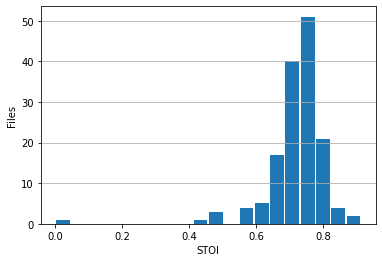

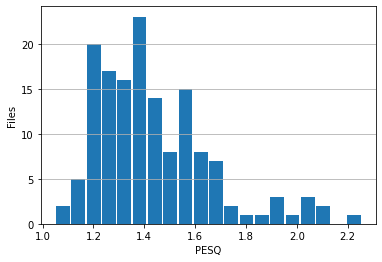

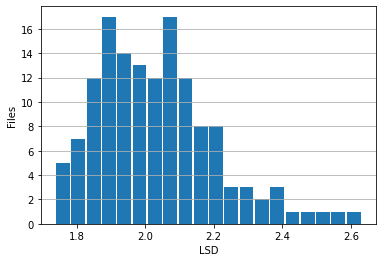

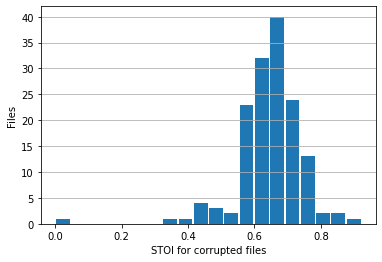

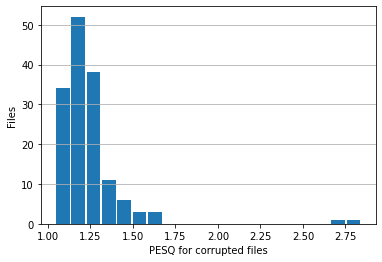

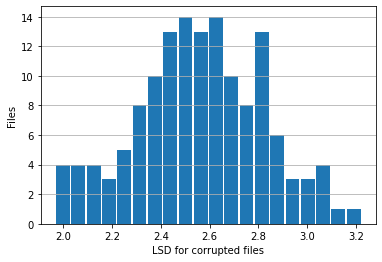

In [14]:
plt.figure()
plt.hist(stoi_scores, 20, rwidth=0.9)
plt.grid(axis='y')
plt.xlabel("STOI")
plt.ylabel("Files")

plt.figure()
plt.hist(pesq_scores, 20, rwidth=0.9)
plt.grid(axis='y')
plt.xlabel("PESQ")
plt.ylabel("Files")

plt.figure()
plt.hist(LSD_reco_scores, 20, rwidth=0.9)
plt.grid(axis='y')
plt.xlabel("LSD")
plt.ylabel("Files")

plt.figure()
plt.hist(stoi_ds_scores, 20, rwidth=0.9)
plt.grid(axis='y')
plt.xlabel("STOI for corrupted files")
plt.ylabel("Files")

plt.figure()
plt.hist(pesq_ds_scores, 20, rwidth=0.9)
plt.grid(axis='y')
plt.xlabel("PESQ for corrupted files")
plt.ylabel("Files")

plt.figure()
plt.hist(LSD_ds_scores, 20, rwidth=0.9)
plt.grid(axis='y')
plt.xlabel("LSD for corrupted files")
plt.ylabel("Files")

# Specific file example

In [ ]:
n = 1
mfcc_X = mfcc_X_list[n]
mfcc_y = mfcc_y_list[n]

# predicted
pred_mfcc_X = predict_mfcc(model, mfcc_X, False)
pred_mfcc_X = icmvn(pred_mfcc_X, X_val_stds_, X_val_means_)

inverted_wav_X_reco = mfcc_to_audio(mfcc=pred_mfcc_X, sr=fs, lifter=0.6, n_fft=640, hop_length=320, fmin=20, fmax=8000, n_mels=128)

# corrupted 
mfcc_X = icmvn(mfcc_X.T, X_val_stds_, X_val_means_) 

inverted_wav_X_ds = mfcc_to_audio(mfcc=mfcc_X, sr=fs, lifter=0.6, n_fft=640, hop_length=320, fmin=20, fmax=8000, n_mels=128)

# clear
mfcc_y = icmvn(mfcc_y.T, y_val_stds_, y_val_means_)
inverted_wav_y = mfcc_to_audio(mfcc=mfcc_y, sr=fs, lifter=0.6, n_fft=640, hop_length=320, fmin=20, fmax=8000, n_mels=128)


sf.write('/pred.wav', inverted_wav_X_reco, 16000)
sf.write('/corrupted.wav', inverted_wav_X_ds, 16000)
sf.write('/uncorrupted.wav', inverted_wav_y, 16000)

#PESQ
pesq_score = pesq(fs, inverted_wav_y, inverted_wav_X_reco,'wb') 

#STOI
stoi_score = stoi(inverted_wav_y, inverted_wav_X_reco, fs, extended=False)

#LSD
ds_lsd, reco_lsd = LSD(inverted_wav_X_ds, inverted_wav_X_reco, inverted_wav_y)

print(f"PESQ: {pesq_score}")
print(f"STOI: {stoi_score}")
print(f"RECO LSD: {reco_lsd}")
print(f"CORR LSD: {ds_lsd}")

PESQ: 1.6062219142913818
STOI: 0.8061670162314246
RECO LSD: 1.9316596984863281
CORR LSD: 2.5445058345794678


# Predicted

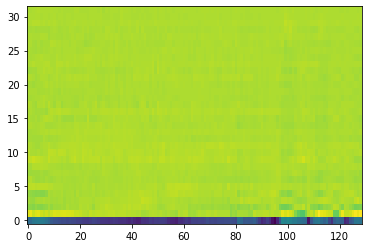

In [ ]:
plt.imshow(pred_mfcc_X, aspect='auto', origin='lower', interpolation='none')
ipd.Audio(inverted_wav_X_reco, rate=16000)

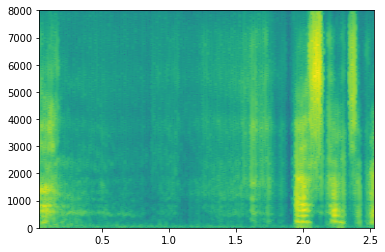

In [ ]:
fs = 16000
NFFT = 1024
Pxx, freqs, bins, im = plt.specgram(inverted_wav_X_reco, NFFT=NFFT,Fs=fs, noverlap=900)
plt.show()

# Clear

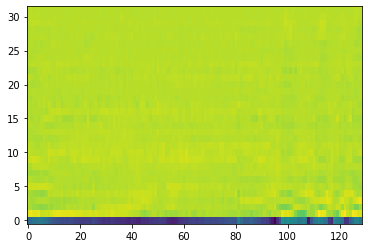

In [ ]:
plt.imshow(mfcc_y, aspect='auto', origin='lower', interpolation='none')
ipd.Audio(inverted_wav_y, rate=16000)

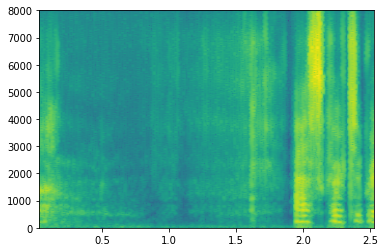

In [ ]:
fs = 16000
NFFT = 1024
Pxx, freqs, bins, im = plt.specgram(inverted_wav_y, NFFT=NFFT,Fs=fs, noverlap=900)
plt.show()

# Corrupted

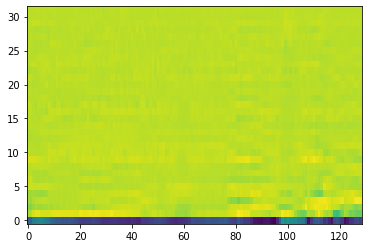

In [ ]:
plt.imshow(mfcc_X, aspect='auto', origin='lower', interpolation='none')
ipd.Audio(inverted_wav_X_ds, rate=16000)

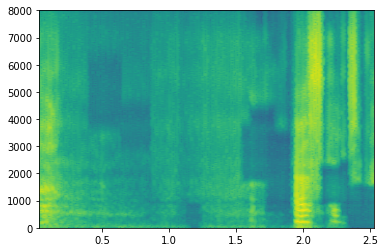

In [ ]:
fs = 16000
NFFT = 1024
Pxx, freqs, bins, im = plt.specgram(inverted_wav_X_ds, NFFT=NFFT,Fs=fs, noverlap=900)
plt.show()

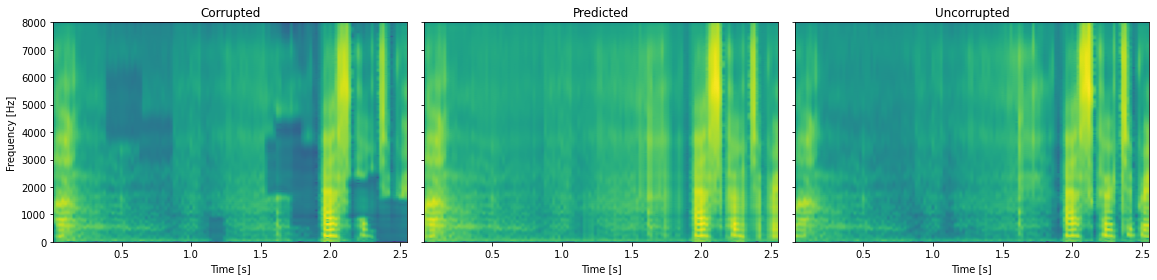

In [ ]:
NFFT = 640
Fs = 16000

fig, axs = plt.subplots(ncols=3, figsize=(16, 4), sharey=True)
Pxx, freqs, bins, im1 = axs[0].specgram(inverted_wav_X_ds, NFFT=NFFT, Fs=Fs, noverlap=int(NFFT/2))
Pxx, freqs, bins, im2 = axs[1].specgram(inverted_wav_X_reco, NFFT=NFFT, Fs=Fs, noverlap=int(NFFT/2))
Pxx, freqs, bins, im3 = axs[2].specgram(inverted_wav_y, NFFT=NFFT, Fs=Fs, noverlap=int(NFFT/2))
axs[0].set_xlabel("Time [s]")
axs[1].set_xlabel("Time [s]")
axs[2].set_xlabel("Time [s]")
axs[0].set_title("Corrupted")
axs[1].set_title("Predicted")
axs[2].set_title("Uncorrupted")
fig.tight_layout()
axs[0].set_ylabel('Frequency [Hz]')
plt.show()